# Chemical space of HIV drugs
Here we analyse chemical space of HIV drugs. The data was obtained from MoleculeNet.ai.

In [25]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from IPython.core.display import display
import numpy as np

In [22]:
df = pd.read_csv('HIV.csv')
df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [23]:
df = df[df['HIV_active']==1]
df = df.reset_index()

In [26]:
PandasTools.AddMoleculeColumnToFrame(df, 'smiles')

,index,smiles,activity,HIV_active,ROMol
0,11,O=C(O)Cc1ccc(SSc2ccc(CC(=O)O)cc2)cc1,CM,1,
1,16,NNP(=S)(NN)c1ccccc1,CM,1,
2,80,O=Nc1ccc(O)c(N=O)c1O,CM,1,
3,203,Oc1ccc(Cl)cc1C(c1cc(Cl)ccc1O)C(Cl)(Cl)Cl,CM,1,
4,234,NNC(=O)c1ccccc1SSc1ccccc1C(=O)NN,CM,1,

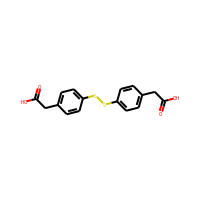
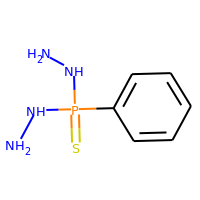
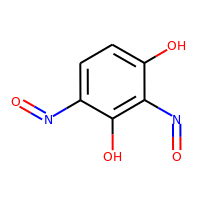
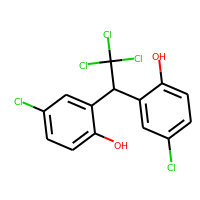
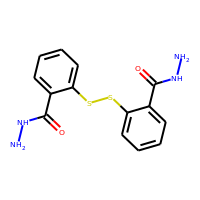

In [27]:
df.head()

In [31]:
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

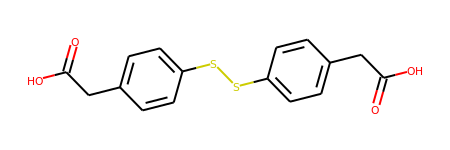

In [36]:
df['ROMol'].iloc[0]

In [39]:
def FPMorganNP(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr


In [89]:
fps = []
for mol in df['ROMol']:
    fps.append(FPMorganNP(mol))
fps = np.array(fps)

# Reduction of dimensionality
There are several algorithms to reduce dimensionality. Here we test most popular one: PCA, MDS and t-SNE. We take euclidean measure for comparison of molecules

In [43]:
from sklearn.decomposition import PCA

In [46]:
pca = PCA(n_components=2)
x= pca.fit_transform(fps)

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

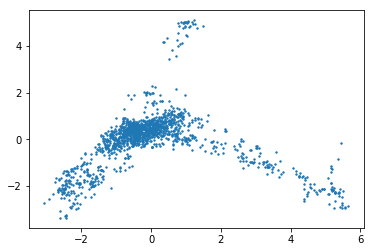

In [58]:
plt.figure()
plt.scatter(x[:,0],x[:,1],s=2)

In [63]:
from sklearn.manifold import MDS

In [65]:
mds = MDS(n_components=2)
x = mds.fit_transform(fps)

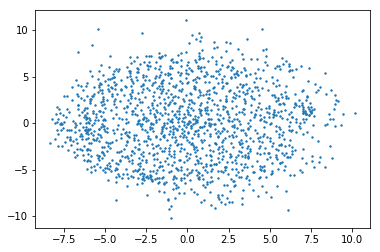

In [67]:
plt.figure()
plt.scatter(x[:,0],x[:,1],s=2)

In [59]:
from sklearn.manifold import TSNE

In [153]:
tsne = TSNE()
x = tsne.fit_transform(fps)

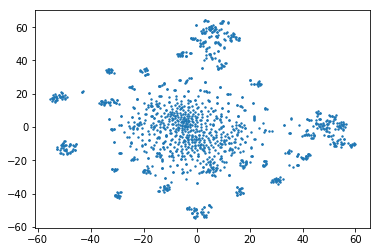

In [108]:
plt.figure()
plt.scatter(x[:,0],x[:,1],s=2)

# Cluster analysis
Obtained space, can be clustered for smaller groups of similar molecules.

In [70]:
from rdkit.ML.Cluster import Butina

In [193]:
fps = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in df['ROMol']]

D = []
for i in range(1,len(fps)):
    sims = DataStructs.BulkTanimotoSimilarity(fps[i],list(fps[:i]))
    D.extend([1-a for a in sims])

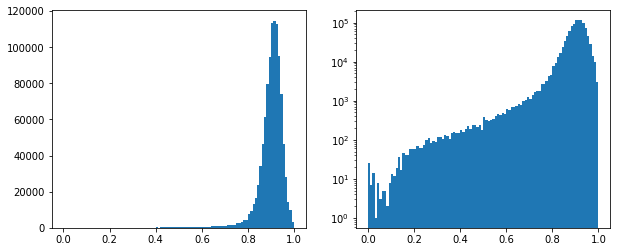

In [216]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
ax1.hist(D, bins = 100, range=(0,1.0));
ax2 = plt.subplot(122)
ax2.hist(D, bins = 100, range=(0,1.0));
ax2.set_yscale('log')


The graph show thata distance between diffrent fingerprints are continuasly distributed. Therfore we have to chose cut-off arbitrally. For that purpose I chose 0.5.

In [204]:
cls = Butina.ClusterData(D,nfps,0.1,isDistData=True)

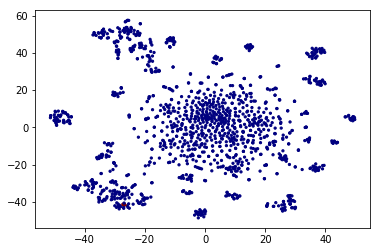

In [205]:
colors_cycle = plt.cm.jet(np.linspace(0,1,1+np.sum([len(a)>5 for a in cls])))

colors = [colors_cycle[0] for a in range(df.shape[0])]
temp =1
for cl in cls:
    if len(cl)>5:
        for a in cl:
            colors[a]= colors_cycle[temp]
        temp+=1
        
plt.figure()
plt.scatter(x[:,0],x[:,1],s=5,c=colors)

Let's see how look the structures of the largest group of molecules.

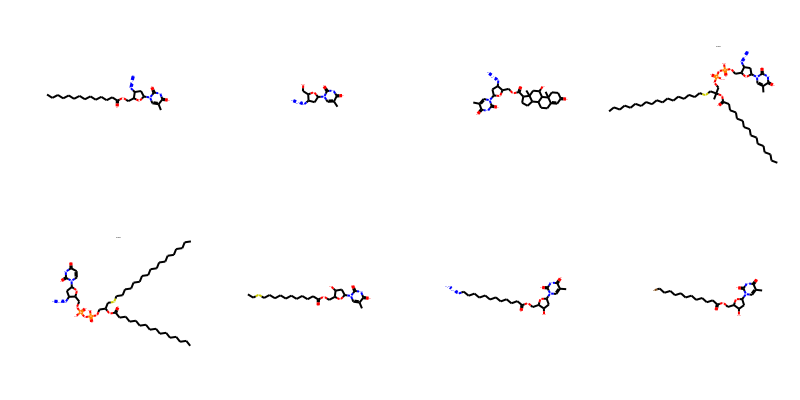

In [191]:
largest_cluser = np.array([len(a) for a in cls]).argmax()
PandasTools.FrameToGridImage(df.iloc[list(cls[largest_cluser])][:8], molsPerRow=4 )

In [172]:
from rdkit.Chem import rdFMCS

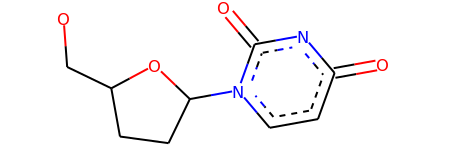

In [192]:
res= rdFMCS.FindMCS(list(df['ROMol'].iloc[list(cls[largest_cluser])]))
Chem.MolFromSmarts(res.smartsString)

This is a substructure which can be found in the largest group of HIV drugs. 